In [2]:
# 데이터 분석 관련 라이브러리
import pandas as pd  # 데이터 프레임 처리
import numpy as np  # 배열, 행렬 연산

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt  # 기본적인 시각화
import seaborn as sns  # 고급 시각화
import matplotlib.font_manager as fm  # 폰트 설정
from matplotlib import rcParams  # 설정 관리

# 맥북에서 한글 설정 (matplotlib에서 한글 깨짐 방지)
plt.rcParams['font.family'] = 'AppleGothic'  # 맥북에서 기본 한글 폰트 적용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split  # 데이터 분할
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # 스케일러
from sklearn.linear_model import LinearRegression, LogisticRegression  # 선형 회귀, 로지스틱 회귀
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # 결정 트리
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # 랜덤 포레스트
from sklearn.svm import SVC, SVR  # 서포트 벡터 머신
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report  # 성능 평가

# 통계 관련 라이브러리
import statsmodels.api as sm  # 통계 모델링
import scipy.stats as stats  # 통계 함수

# 기타 라이브러리
import os  # 운영체제 관련 기능
import sys  # 시스템 관련 기능
import re  # 정규 표현식
import json  # JSON 파일 처리
import datetime  # 날짜 및 시간 처리
import pickle  # 객체 직렬화 및 역직렬화
import requests  # HTTP 요청
import random  # 난수 생성
import math  # 수학 함수


In [2]:

import os
import pandas as pd

# 파일이 있는 폴더와 저장할 폴더 경로 설정
input_folder = '/Users/parkjunhyeok/콤파스_크롤링_전처리및상권정보가공/부동산매물데이터전처리'
output_folder = '/Users/parkjunhyeok/콤파스_크롤링_전처리및상권정보가공/부동산매물데이터_컬럼및전처리'

# 저장할 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# 폴더 내 모든 csv 파일을 읽고 전처리한 후 저장하는 코드
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # CSV 파일 읽기
        file_path = os.path.join(input_folder, file_name)
        df = pd.read_csv(file_path)
        
        # 공급면적, 전용면적, 현재층, 총층을 추출하는 함수
        def extract_areas_and_floors(area_str):
            area_str = area_str.split(', ')
            supply_area, exclusive_area = area_str[0].split('/')
            current_floor, total_floors = area_str[1].split('/')
            return supply_area, exclusive_area, current_floor, total_floors

        # 가격에서 보증금과 월세를 추출하는 함수
        def extract_deposit_and_rent(price_str):
            if '억' in price_str:  # 매매인 경우
                return price_str, None  # 매매가로 설정, 월세는 없음
            else:
                parts = price_str.split('/')
                if len(parts) == 2:
                    return parts[0], parts[1]  # 보증금과 월세
                else:
                    return price_str, None  # 월세가 없는 경우

        # 공급면적, 전용면적, 현재층, 총층 컬럼 추가
        df[['공급면적', '전용면적', '현재층', '총층']] = df['면적 및 층수'].apply(lambda x: pd.Series(extract_areas_and_floors(x)))

        # 공급종류, 보증금, 월세 컬럼 추가
        df['공급종류'] = df['가격'].apply(lambda x: '매매' if '억' in x else '월세')
        df[['보증금', '월세']] = df['가격'].apply(lambda x: pd.Series(extract_deposit_and_rent(x)))

        # 매매인 경우 보증금과 월세를 NaN으로 설정하고, 매매가 컬럼을 추가
        df['보증금'] = df.apply(lambda row: np.nan if row['공급종류'] == '매매' else row['보증금'], axis=1)
        df['월세'] = df.apply(lambda row: np.nan if row['공급종류'] == '매매' else row['월세'], axis=1)

        # 매매가 컬럼 추가
        df['매매가'] = df.apply(lambda row: row['가격'] if row['공급종류'] == '매매' else np.nan, axis=1)
        
        # '전용면적'에서 숫자만 남기고 제곱기호(²) 제거
        df['전용면적'] = df['전용면적'].apply(lambda x: ''.join(filter(str.isdigit, str(x))))
        df['전용면적'] = df['전용면적'].str.replace('²', '', regex=False)
        
        # '총층'에서 지하층(B1, B2 등)을 포함하여 숫자만 남기고 나머지 문자열 제거
        df['총층'] = df['총층'].apply(lambda x: ''.join(filter(str.isdigit, str(x))) if 'B' not in str(x) else str(x))
        
        # 전처리된 데이터 CSV로 저장
        output_file_path = os.path.join(output_folder, file_name)
        df.to_csv(output_file_path, index=False)

output_folder


'/Users/parkjunhyeok/콤파스_크롤링_전처리및상권정보가공/부동산매물데이터_컬럼및전처리'

### 모든 매물데이터 concat

In [24]:
# 전처리된 전체 파일이 있는 폴더 경로 설정
processed_folder = '/Users/parkjunhyeok/콤파스_크롤링_전처리및상권정보가공/성남시부동산매물데이터_컬럼및전처리'

# 폴더 내 모든 CSV 파일을 읽고 하나의 DataFrame으로 합치기
all_files = [file for file in os.listdir(processed_folder) if file.endswith('.csv')]

# 각 파일을 읽어와서 하나의 리스트로 저장
dfs = []
for file_name in all_files:
    file_path = os.path.join(processed_folder, file_name)
    df = pd.read_csv(file_path)
    dfs.append(df)

# 리스트에 저장된 DataFrame을 하나로 합치기
merged_df = pd.concat(dfs, ignore_index=True)

merged_df


,이름,가격,면적 및 층수,센터명칭,공급면적,전용면적,현재층,총층,공급종류,보증금,월세,매매가
0,지식산업센터,"19억 8,000","679/342m², 3/15층",성남 SK V1 tower,679,342,3,15,매매,NaN,NaN,"19억 8,000"
1,지식산업센터,"1억 3,000/1,100","1504/873m², 1/7층",중앙인더스피아3,1504,873,1,7,매매,NaN,NaN,"1억 3,000/1,100"
2,지식산업센터,"1,500/150","257/128m², 13/16층",성남 센트럴비즈타워 2차,257,128,13,16,월세,"1,500",150.0,NaN
3,지식산업센터,"2,000/190","219/110m², 1/16층",성남 센트럴비즈타워 2차,219,110,1,16,월세,"2,000",190.0,NaN
4,지식산업센터,"2,000/150","246/128m², 11/13층",중앙이노테크 지식산업센터,246,128,11,13,월세,"2,000",150.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
888,지식산업센터,"4,000/320","426/298m², 5/9층",정보없음,426,298,5,9,월세,"4,000",320.0,NaN
889,지식산업센터,"2,000/170","215/150m², 8/9층",정보없음,215,150,8,9,월세,"2,000",170.0,NaN
890,지식산업센터,"1억 2,000","74/54m², B2/9층",분당테크노파크C동,74,54,B2,9,매매,NaN,NaN,"1억 2,000"
891,지식산업센터,"1억 4,000","55/33m², 6/7층",정보없음,55,33,6,7,매매,NaN,NaN,"1억 4,000"


In [25]:
merged_df.to_csv('./성남시_데이터_1차가공.csv', index=False, encoding='utf-8-sig')

In [ ]:
# merged_df = pd.read_csv('/Users/parkjunhyeok/콤파스_크롤링_전처리및상권정보가공/의왕_군포시_데이터_1차가공.csv')

In [26]:
merged_df

,이름,가격,면적 및 층수,센터명칭,공급면적,전용면적,현재층,총층,공급종류,보증금,월세,매매가
0,지식산업센터,"19억 8,000","679/342m², 3/15층",성남 SK V1 tower,679,342,3,15,매매,NaN,NaN,"19억 8,000"
1,지식산업센터,"1억 3,000/1,100","1504/873m², 1/7층",중앙인더스피아3,1504,873,1,7,매매,NaN,NaN,"1억 3,000/1,100"
2,지식산업센터,"1,500/150","257/128m², 13/16층",성남 센트럴비즈타워 2차,257,128,13,16,월세,"1,500",150.0,NaN
3,지식산업센터,"2,000/190","219/110m², 1/16층",성남 센트럴비즈타워 2차,219,110,1,16,월세,"2,000",190.0,NaN
4,지식산업센터,"2,000/150","246/128m², 11/13층",중앙이노테크 지식산업센터,246,128,11,13,월세,"2,000",150.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
888,지식산업센터,"4,000/320","426/298m², 5/9층",정보없음,426,298,5,9,월세,"4,000",320.0,NaN
889,지식산업센터,"2,000/170","215/150m², 8/9층",정보없음,215,150,8,9,월세,"2,000",170.0,NaN
890,지식산업센터,"1억 2,000","74/54m², B2/9층",분당테크노파크C동,74,54,B2,9,매매,NaN,NaN,"1억 2,000"
891,지식산업센터,"1억 4,000","55/33m², 6/7층",정보없음,55,33,6,7,매매,NaN,NaN,"1억 4,000"


In [29]:
성남시시_데이터_1차가공 = merged_df.copy()

### 지산데이터랑 지산매물데이터랑 합치기 (공실률이랑 관계를 보기 위한)

In [6]:
지산데이터 = pd.read_csv('/Users/parkjunhyeok/콤파스_크롤링_전처리및상권정보가공/군포_의왕_지산.csv', encoding='utf-8-sig')

In [7]:
지산데이터['지식산업센터명칭'].value_counts()

지식산업센터명칭
동영벤처스텔         2
PK벤처타워         1
더리브비즈원         1
엠테크노센터         1
예성팩토링          1
우경타워           1
한림벤처타운         1
한림휴먼타워         1
한솔테크노타운        1
대영골든밸리         1
대현 테크노월드       1
벽산선영테크노피아      1
에이스하이테크시티군포    1
성우벤처빌          1
성진아파트형         1
에이스청계타워        1
에이스하이테크비젼21    1
에이엘티 지식산업센터    1
원테크노           1
의왕월드비젼         1
에이프로테크노피아      1
에스에이타워         1
SK벤티움          1
삼성IT타워         1
군포IT밸리         1
군포LS지식산업센터     1
군포에이스더블유밸리     1
군포제일공단         1
금봉테크노벨리1차      1
금봉테크노벨리2차      1
대영타워           1
삼풍데파트          1
아이벨리군포         1
삼풍프라자          1
성우빌딩           1
센트럴비즈파크        1
스카이비즈          1
신광프라자          1
신라테크노빌         1
신일IT유토         1
인덕원IT밸리        1
Name: count, dtype: int64

In [9]:
의왕_군포시_데이터_1차가공['센터명칭'].value_counts().head(10)

센터명칭
센트럴비즈파크 지식산업센터    87
정보없음              80
엠테크노센터            53
에이스 하이테크시티군포      45
군포아이티밸리           44
LT삼보 스카이비즈        41
성진아파트형공장          36
에이스 청계타워          32
-                 30
한림벤처타운            19
Name: count, dtype: int64

### 지식산업명칭 전처리

In [30]:
의왕_군포시_데이터_1차가공['보증금'].value_counts()

보증금
2,000    66
1,000    55
1,500    46
500      25
1,800    21
         ..
8,150     1
3,200     1
8,000     1
6,000     1
5,600     1
Name: count, Length: 61, dtype: int64

In [10]:
의왕_군포시_데이터_1차가공[의왕_군포시_데이터_1차가공['센터명칭'] == '센트럴비즈파크 지식산업센터']

,이름,가격,면적 및 층수,센터명칭,공급면적,전용면적,현재층,총층,공급종류,보증금,월세,매매가
247,지식산업센터,550/55,"89/44m², 5/14층",센트럴비즈파크 지식산업센터,89,44,5,14,월세,550,55.0,NaN
248,지식산업센터,"1,000/100","150/75m², 3/14층",센트럴비즈파크 지식산업센터,150,75,3,14,월세,"1,000",100.0,NaN
250,지식산업센터,"1,000/95","150/75m², 3/14층",센트럴비즈파크 지식산업센터,150,75,3,14,월세,"1,000",95.0,NaN
254,지식산업센터,"1,000/80","155/77m², B1/14층",센트럴비즈파크 지식산업센터,155,77,B1,14,월세,"1,000",80.0,NaN
262,지식산업센터,500/45,"59/29m², 9/14층",센트럴비즈파크 지식산업센터,59,29,9,14,월세,500,45.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
573,지식산업센터,500/55,"76/38m², 9/14층",센트럴비즈파크 지식산업센터,76,38,9,14,월세,500,55.0,NaN
574,지식산업센터,"3,000/120","110/55m², 2/14층",센트럴비즈파크 지식산업센터,110,55,2,14,월세,"3,000",120.0,NaN
579,지식산업센터,500/45,"59/29m², 11/14층",센트럴비즈파크 지식산업센터,59,29,11,14,월세,500,45.0,NaN
591,지식산업센터,"1,000/75","108/54m², 3/14층",센트럴비즈파크 지식산업센터,108,54,3,14,월세,"1,000",75.0,NaN


In [31]:
mapping_dict = {
    # 기존 명칭 (의왕_군포시_데이터_1차가공) : 변경할 명칭 (지산데이터 기준)
    '엠테크노센터': '엠테크노센터',
    '에이스 하이테크시티군포': '에이스하이테크시티군포',
    '군포아이티밸리': '군포IT밸리',
    'LT삼보 스카이비즈': '스카이비즈',
    '성진아파트형공장': '성진아파트형',
    '에이스 청계타워': '에이스청계타워',
    '한림벤처타운': '한림벤처타운',
    '센트럴비즈파크 지식산업센터': '센트럴비즈파크'
}
의왕_군포시_데이터_1차가공['센터명칭'] = 의왕_군포시_데이터_1차가공['센터명칭'].replace(mapping_dict)


In [12]:
의왕_군포시_데이터_1차가공['센터명칭'].value_counts()


센터명칭
센트럴비즈파크                    87
정보없음                       80
엠테크노센터                     53
에이스하이테크시티군포                45
군포IT밸리                     44
스카이비즈                      41
성진아파트형                     36
에이스청계타워                    32
-                          30
한림벤처타운                     19
오전동 150-24 공장 ((주)에이엘티)    19
한솔테크노타운                    19
PK벤처타워                     18
예성펙토링                      17
한림휴먼타워                     12
의왕월드비전                      9
신라테크노빌                      9
대영골든밸리                      8
신일IT유토지식산업센터                7
삼풍데파트                       6
금봉테크노벨리아파트형공장               4
성우아파트형공장                    3
동영벤처스텔                      3
금봉아파트형공장                    2
Name: count, dtype: int64

### 머지하기 

In [32]:
# 3. 두 데이터프레임 병합 (의왕_군포시_데이터_1차가공의 '센터명칭'과 지산데이터의 '지식산업센터명칭'을 기준)
의왕_군포시_지산데이터_1차가공데이터_머지_df = 의왕_군포시_데이터_1차가공.merge(
    지산데이터,
    left_on='센터명칭',
    right_on='지식산업센터명칭',
    how='left'  # 혹은 'inner' 등 상황에 맞게 선택
)

In [33]:
# 공실률데이터가 nan인 경우 그 행 삭제

의왕_군포시_지산데이터_1차가공데이터_머지_df = 의왕_군포시_지산데이터_1차가공데이터_머지_df.dropna(subset=['공실률'])

In [34]:
의왕_군포시_지산데이터_1차가공데이터_머지_df.head()

,이름,가격,면적 및 층수,센터명칭,공급면적,전용면적,현재층,총층,공급종류,보증금,월세,매매가,시군명,지식산업센터명칭,위도,경도,소재지지번주소,소재지도로명주소,용도지역,부지면적(㎡),건축면적(㎡),층수(지하/지상),공장시설면적(㎡),기타산업시설면적(㎡),지원시설면적(㎡),공동시설면적(㎡),유치가능업체수,입주업체수,공장동수,분양형태,공사진행상황,허가일자,착공일자,준공일자,사용승인일,데이터기준일자,공실률
21,지식산업센터,9억,"599/444m², 5/7층",동영벤처스텔,599,444,5,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882
22,지식산업센터,9억,"599/444m², 5/7층",동영벤처스텔,599,444,5,7,매매,NaN,NaN,9억,의왕시,동영벤처스텔,37.355560,126.965291,경기도 의왕시 오전동 172번지,경기도 의왕시 오전공업길 22,공업,1066.0,4023.54,B0/7,2924.33,NaN,1099.21,NaN,15.0,15.0,1.0,분양,준공,2010-01-01,2000-08-07,2001-02-20,NaN,2024-04-24,0.000000
23,지식산업센터,9억,"599/444m², 5/7층",동영벤처스텔,599,444,5,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882
24,지식산업센터,9억,"599/444m², 5/7층",동영벤처스텔,599,444,5,7,매매,NaN,NaN,9억,의왕시,동영벤처스텔,37.355560,126.965291,경기도 의왕시 오전동 172번지,경기도 의왕시 오전공업길 22,공업,1066.0,4023.54,B0/7,2924.33,NaN,1099.21,NaN,15.0,15.0,1.0,분양,준공,2010-01-01,2000-08-07,2001-02-20,NaN,2024-04-24,0.000000
36,지식산업센터,9억,"599/444m², 5/7층",동영벤처스텔,599,444,5,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882


In [37]:
의왕_군포시_지산데이터_1차가공데이터_머지_df['보증금'].value_counts()

보증금
1000.0    42
2000.0    30
1500.0    29
500.0     22
1800.0    14
3000.0    11
2500.0     9
1600.0     7
5000.0     7
1100.0     7
600.0      7
1700.0     6
7000.0     5
750.0      4
1400.0     4
2300.0     4
800.0      4
1300.0     4
1200.0     3
550.0      3
2900.0     3
2200.0     2
5500.0     2
5100.0     2
3500.0     2
4950.0     2
1250.0     2
2400.0     2
4500.0     1
2700.0     1
4600.0     1
650.0      1
4800.0     1
4590.0     1
7300.0     1
3600.0     1
2100.0     1
9500.0     1
9000.0     1
4700.0     1
5040.0     1
6900.0     1
2600.0     1
4000.0     1
1370.0     1
2150.0     1
2750.0     1
7500.0     1
700.0      1
2350.0     1
5900.0     1
8000.0     1
6000.0     1
3400.0     1
5600.0     1
Name: count, dtype: int64

### 컬럼들 정제

In [36]:
import pandas as pd
import numpy as np

# 날짜형 컬럼 변환
date_cols = ['허가일자', '착공일자', '준공일자', '사용승인일', '데이터기준일자']
for col in date_cols:
    if col in 의왕_군포시_지산데이터_1차가공데이터_머지_df.columns:
        의왕_군포시_지산데이터_1차가공데이터_머지_df[col] = pd.to_datetime(의왕_군포시_지산데이터_1차가공데이터_머지_df[col], errors='coerce')

# 가격 컬럼 변환 (예: "9억" → 900,000,000)
def convert_price(price):
    if pd.isnull(price):
        return price
    if isinstance(price, str):
        price = price.strip().replace(',', '')  # 콤마 제거
        if price.endswith('억'):
            try:
                num = float(price.replace('억', '').strip())
                return num * 100000000
            except:
                return np.nan
        try:
            return float(price)
        except:
            return np.nan
    return price

if '가격' in 의왕_군포시_지산데이터_1차가공데이터_머지_df.columns:
    의왕_군포시_지산데이터_1차가공데이터_머지_df['가격'] = 의왕_군포시_지산데이터_1차가공데이터_머지_df['가격'].apply(convert_price)

# 숫자로 변환할 컬럼들
numeric_cols = ['공급면적', '전용면적', '현재층', '총층', '입주업체수', '공장동수', '공실률', '보증금']
for col in numeric_cols:
    if col in 의왕_군포시_지산데이터_1차가공데이터_머지_df.columns:
        의왕_군포시_지산데이터_1차가공데이터_머지_df[col] = 의왕_군포시_지산데이터_1차가공데이터_머지_df[col].astype(str).str.replace(',', '', regex=True)
        의왕_군포시_지산데이터_1차가공데이터_머지_df[col] = pd.to_numeric(의왕_군포시_지산데이터_1차가공데이터_머지_df[col], errors='coerce')



### 평당 월세 , 평수계산 , 연면적계산


In [38]:

pd.set_option('display.max_columns', None)
의왕_군포시_지산데이터_1차가공데이터_머지_df.head()

,이름,가격,면적 및 층수,센터명칭,공급면적,전용면적,현재층,총층,공급종류,보증금,월세,매매가,시군명,지식산업센터명칭,위도,경도,소재지지번주소,소재지도로명주소,용도지역,부지면적(㎡),건축면적(㎡),층수(지하/지상),공장시설면적(㎡),기타산업시설면적(㎡),지원시설면적(㎡),공동시설면적(㎡),유치가능업체수,입주업체수,공장동수,분양형태,공사진행상황,허가일자,착공일자,준공일자,사용승인일,데이터기준일자,공실률
21,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882
22,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,의왕시,동영벤처스텔,37.355560,126.965291,경기도 의왕시 오전동 172번지,경기도 의왕시 오전공업길 22,공업,1066.0,4023.54,B0/7,2924.33,NaN,1099.21,NaN,15.0,15.0,1.0,분양,준공,2010-01-01,2000-08-07,2001-02-20,NaT,2024-04-24,0.000000
23,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882
24,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,의왕시,동영벤처스텔,37.355560,126.965291,경기도 의왕시 오전동 172번지,경기도 의왕시 오전공업길 22,공업,1066.0,4023.54,B0/7,2924.33,NaN,1099.21,NaN,15.0,15.0,1.0,분양,준공,2010-01-01,2000-08-07,2001-02-20,NaT,2024-04-24,0.000000
36,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882


In [39]:

# 공급면적을 평(㎡ -> 평)으로 변환 (1평 = 3.3058㎡)
의왕_군포시_지산데이터_1차가공데이터_머지_df["공급면적(평)"] = 의왕_군포시_지산데이터_1차가공데이터_머지_df["공급면적"] / 3.3058

# 전용면적을 평으로 변환
의왕_군포시_지산데이터_1차가공데이터_머지_df["전용면적(평)"] = 의왕_군포시_지산데이터_1차가공데이터_머지_df["전용면적"] / 3.3058

# 연면적 계산 (건축면적 * 총층)
의왕_군포시_지산데이터_1차가공데이터_머지_df["연면적(㎡)"] = 의왕_군포시_지산데이터_1차가공데이터_머지_df["건축면적(㎡)"] * 의왕_군포시_지산데이터_1차가공데이터_머지_df["총층"]
의왕_군포시_지산데이터_1차가공데이터_머지_df["연면적(평)"] = 의왕_군포시_지산데이터_1차가공데이터_머지_df["연면적(㎡)"] / 3.3058

# 평당 월 임대료 계산 (월세 / 공급면적(평)), 월세 데이터가 존재하지 않으므로 임의 값 설정 필요
의왕_군포시_지산데이터_1차가공데이터_머지_df["평당 월 임대료"] = 의왕_군포시_지산데이터_1차가공데이터_머지_df["월세"] / 의왕_군포시_지산데이터_1차가공데이터_머지_df["공급면적(평)"]


In [40]:
의왕_군포시_지산데이터_1차가공데이터_머지_df.head()

,이름,가격,면적 및 층수,센터명칭,공급면적,전용면적,현재층,총층,공급종류,보증금,월세,매매가,시군명,지식산업센터명칭,위도,경도,소재지지번주소,소재지도로명주소,용도지역,부지면적(㎡),건축면적(㎡),층수(지하/지상),공장시설면적(㎡),기타산업시설면적(㎡),지원시설면적(㎡),공동시설면적(㎡),유치가능업체수,입주업체수,공장동수,분양형태,공사진행상황,허가일자,착공일자,준공일자,사용승인일,데이터기준일자,공실률,공급면적(평),전용면적(평),연면적(㎡),연면적(평),평당 월 임대료
21,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882,181.196685,134.309396,20867.00,6312.239095,NaN
22,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,의왕시,동영벤처스텔,37.355560,126.965291,경기도 의왕시 오전동 172번지,경기도 의왕시 오전공업길 22,공업,1066.0,4023.54,B0/7,2924.33,NaN,1099.21,NaN,15.0,15.0,1.0,분양,준공,2010-01-01,2000-08-07,2001-02-20,NaT,2024-04-24,0.000000,181.196685,134.309396,28164.78,8519.807611,NaN
23,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882,181.196685,134.309396,20867.00,6312.239095,NaN
24,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,의왕시,동영벤처스텔,37.355560,126.965291,경기도 의왕시 오전동 172번지,경기도 의왕시 오전공업길 22,공업,1066.0,4023.54,B0/7,2924.33,NaN,1099.21,NaN,15.0,15.0,1.0,분양,준공,2010-01-01,2000-08-07,2001-02-20,NaT,2024-04-24,0.000000,181.196685,134.309396,28164.78,8519.807611,NaN
36,지식산업센터,900000000.0,"599/444m², 5/7층",동영벤처스텔,599,444,5.0,7,매매,NaN,NaN,9억,군포시,동영벤처스텔,37.353756,126.949440,경기도 군포시 당동 135-4,경기도 군포시 공단로 97,일반공업,724.0,2981.00,B1/7,1907.00,NaN,1074.00,NaN,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882,181.196685,134.309396,20867.00,6312.239095,NaN


In [41]:
# '매매가' 컬럼 변환: '억' 단위 제거 후 숫자로 변환

의왕_군포시_지산데이터_1차가공데이터_머지_df["매매가"] = (
    의왕_군포시_지산데이터_1차가공데이터_머지_df["매매가"]
    .astype(str)  # 문자열로 변환
    .str.replace(" ", "")  # 공백 제거
    .str.replace(",", "")  # 쉼표 제거
    .str.replace("억", "")  # '억' 제거
    .apply(lambda x: float(x) * 1e8 if x.replace(".", "").isdigit() else None)  # 숫자로 변환 (억 단위 처리)
)


# 불필요한 컬럼 제거 (기타산업시설면적, 공동시설면적)
의왕_군포시_지산데이터_1차가공데이터_머지_df.drop(columns=["기타산업시설면적(㎡)", "공동시설면적(㎡)"], inplace=True)

In [42]:
의왕_군포시_지산데이터_1차가공데이터_머지_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 21 to 605
Data columns (total 40 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   이름         435 non-null    object        
 1   가격         49 non-null     float64       
 2   면적 및 층수    435 non-null    object        
 3   센터명칭       435 non-null    object        
 4   공급면적       435 non-null    int64         
 5   전용면적       435 non-null    int64         
 6   현재층        399 non-null    float64       
 7   총층         435 non-null    int64         
 8   공급종류       435 non-null    object        
 9   보증금        266 non-null    float64       
 10  월세         263 non-null    float64       
 11  매매가        165 non-null    float64       
 12  시군명        435 non-null    object        
 13  지식산업센터명칭   435 non-null    object        
 14  위도         435 non-null    float64       
 15  경도         435 non-null    float64       
 16  소재지지번주소    435 non-null    object        
 17  소

In [43]:
의왕_군포시_지산데이터_1차가공데이터_머지_df.drop(columns=['가격', '지식산업센터명칭', '면적 및 층수', '이름', '소재지지번주소', '공급면적', '전용면적', '층수(지하/지상)'], inplace=True)


In [44]:
의왕_군포시_지산데이터_1차가공데이터_머지_df.head(2)

,센터명칭,현재층,총층,공급종류,보증금,월세,매매가,시군명,위도,경도,소재지도로명주소,용도지역,부지면적(㎡),건축면적(㎡),공장시설면적(㎡),지원시설면적(㎡),유치가능업체수,입주업체수,공장동수,분양형태,공사진행상황,허가일자,착공일자,준공일자,사용승인일,데이터기준일자,공실률,공급면적(평),전용면적(평),연면적(㎡),연면적(평),평당 월 임대료
21,동영벤처스텔,5.0,7,매매,NaN,NaN,900000000.0,군포시,37.353756,126.949440,경기도 군포시 공단로 97,일반공업,724.0,2981.00,1907.00,1074.00,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04,64.705882,181.196685,134.309396,20867.00,6312.239095,NaN
22,동영벤처스텔,5.0,7,매매,NaN,NaN,900000000.0,의왕시,37.355560,126.965291,경기도 의왕시 오전공업길 22,공업,1066.0,4023.54,2924.33,1099.21,15.0,15.0,1.0,분양,준공,2010-01-01,2000-08-07,2001-02-20,NaT,2024-04-24,0.000000,181.196685,134.309396,28164.78,8519.807611,NaN


## 결측치 대치

In [45]:
의왕_군포시_지산데이터_1차가공데이터_머지_df.columns

Index(['센터명칭', '현재층', '총층', '공급종류', '보증금', '월세', '매매가', '시군명', '위도', '경도',
       '소재지도로명주소', '용도지역', '부지면적(㎡)', '건축면적(㎡)', '공장시설면적(㎡)', '지원시설면적(㎡)',
       '유치가능업체수', '입주업체수', '공장동수', '분양형태', '공사진행상황', '허가일자', '착공일자', '준공일자',
       '사용승인일', '데이터기준일자', '공실률', '공급면적(평)', '전용면적(평)', '연면적(㎡)', '연면적(평)',
       '평당 월 임대료'],
      dtype='object')

In [52]:
# grouped_df = 의왕_군포시_지산데이터_1차가공데이터_머지_df.groupby(['시군명', '센터명칭']).agg({
#     '보증금': 'max',
#     '월세': 'median',
#     '매매가': 'median',
#     '공급면적(평)': 'mean',
#     '전용면적(평)': 'mean',
#     '현재층': 'mean',
#     '공실률': 'mean',
#     '건축면적(㎡)': 'mean',
#     '연면적(㎡)': 'mean',
#     '평당 월 임대료': 'median'
# }).reset_index()
# 그룹화된 데이터(grouped_df)를 만들면서 수치형 컬럼과 범주형/날짜형 컬럼을 동시에 처리

# 수치형 컬럼: 평균 또는 최대값
numeric_agg = {
    '보증금': 'max',
    '월세': 'mean',
    '매매가': 'mean',
    '공급면적(평)': 'mean',
    '전용면적(평)': 'mean',
    '현재층': 'mean',
    '공실률': 'mean',
    '건축면적(㎡)': 'mean',
    '연면적(㎡)': 'mean',
    '평당 월 임대료': 'mean'
}

# 범주형 및 날짜형 컬럼: 최빈값(mode)
categorical_cols = ['총층', '공급종류', '위도', '경도', '소재지도로명주소', '용도지역', '부지면적(㎡)', 
                    '공장시설면적(㎡)', '지원시설면적(㎡)', '유치가능업체수', '입주업체수', '공장동수', 
                    '분양형태', '공사진행상황', '허가일자', '착공일자', '준공일자', '사용승인일', '데이터기준일자']

# 그룹화 및 집계 (수치형: 평균 또는 최대값, 범주형: 최빈값)
grouped_df = 의왕_군포시_지산데이터_1차가공데이터_머지_df.groupby(['시군명', '센터명칭']).agg({
    **numeric_agg, 
    **{col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in categorical_cols}
}).reset_index()


In [53]:
grouped_df

,시군명,센터명칭,보증금,월세,매매가,공급면적(평),전용면적(평),현재층,공실률,건축면적(㎡),연면적(㎡),평당 월 임대료,총층,공급종류,위도,경도,소재지도로명주소,용도지역,부지면적(㎡),공장시설면적(㎡),지원시설면적(㎡),유치가능업체수,입주업체수,공장동수,분양형태,공사진행상황,허가일자,착공일자,준공일자,사용승인일,데이터기준일자
0,군포시,PK벤처타워,9500.0,461.250000,NaN,232.419787,143.048245,1.888889,0.000000,7093.00,4.216394e+04,2.544600,6,월세,37.356415,126.957155,경기도 군포시 산본로54번안길 13,일반공업,1531.0,4232.00,2861.00,13.0,13.0,1.0,임대,사용승인,2006-05-04,2007-05-20,2008-02-01,2008-06-10,2024-03-04
1,군포시,군포IT밸리,9000.0,207.500000,4.646916e+12,80.801511,40.741067,11.536585,0.801282,137033.00,4.612406e+06,2.449329,34,월세,37.349665,126.953501,경기도 군포시 고산로148번길 17,일반공업,17658.0,63287.00,73746.00,624.0,619.0,2.0,분양,사용승인,2010-10-07,2010-12-10,2013-06-01,2013-06-28,2024-03-04
2,군포시,동영벤처스텔,NaN,NaN,9.000000e+08,181.196685,134.309396,5.000000,64.705882,2981.00,2.086700e+04,NaN,7,매매,37.353756,126.949440,경기도 군포시 공단로 97,일반공업,724.0,1907.00,1074.00,17.0,6.0,1.0,분양,사용승인,1998-11-27,1999-08-30,2000-04-01,2000-04-11,2024-03-04
3,군포시,삼풍데파트,1500.0,135.000000,3.300000e+12,99.522052,67.759695,3.166667,0.000000,4305.00,2.152500e+04,1.356483,5,월세,37.354000,126.953322,경기도 군포시 당정로 57,일반공업,1001.0,3721.00,584.00,13.0,13.0,1.0,분양,사용승인,1991-12-12,1991-12-27,1992-07-01,1992-07-27,2024-03-04
4,군포시,센트럴비즈파크,3000.0,77.107692,4.088615e+12,53.052003,26.327813,6.831325,34.426230,27342.00,3.827880e+05,2.490174,14,월세,37.357238,126.953807,경기도 군포시 공단로140번길 38,일반공업,3605.0,22413.00,4929.00,305.0,200.0,1.0,분양,사용승인,2020-01-31,2020-09-03,2022-07-01,2022-07-21,2024-03-04
5,군포시,스카이비즈,7300.0,209.423077,1.822660e+12,91.966964,46.156865,7.027027,15.196078,36496.00,5.109440e+05,2.975581,14,월세,37.360034,126.950241,경기도 군포시 농심로 2,일반공업,4371.0,16614.00,19882.00,204.0,173.0,1.0,분양+임대,사용승인,2018-04-23,2018-05-30,2020-04-01,2020-04-09,2024-03-04
6,군포시,신라테크노빌,5000.0,287.142857,1.200000e+13,138.880486,97.202896,4.000000,37.662338,29940.00,3.027267e+05,3.047334,9,월세,37.355304,126.950908,경기도 군포시 당정로 90,일반공업,6760.0,25157.00,4784.00,77.0,48.0,1.0,분양,사용승인,1995-04-10,1995-06-13,1998-09-01,1998-09-29,2024-03-04
7,군포시,에이스하이테크시티군포,3000.0,140.588235,3.417004e+12,73.473558,36.898112,7.564103,0.000000,50549.00,7.076860e+05,2.359300,14,매매,37.357192,126.955524,경기도 군포시 공단로140번길 52,일반공업,5721.0,46228.00,4322.00,254.0,254.0,1.0,분양,사용승인,2017-05-25,2017-09-05,2019-09-01,2019-09-06,2024-03-04
8,군포시,엠테크노센터,7500.0,360.833333,5.368048e+12,117.974469,60.950622,7.333333,24.908425,68302.00,8.879260e+05,2.782031,13,매매,37.356999,126.954723,경기도 군포시 공단로140번길 46,일반공업,8717.0,33213.00,35088.00,273.0,205.0,1.0,분양+임대,사용승인,2015-11-10,2016-07-01,2018-02-01,2018-02-27,2024-03-04
9,군포시,한림벤처타운,3500.0,219.285714,2.520380e+12,93.949709,64.034186,3.894737,20.000000,22232.00,1.603044e+05,2.395326,7,월세,37.369657,126.945698,경기도 군포시 공단로 284,일반공업,4542.0,20819.00,1413.00,95.0,76.0,1.0,분양,사용승인,2002-04-10,2002-04-18,2003-05-01,2003-03-17,2024-03-04


In [54]:
grouped_df.to_csv('./군포의왕시_데이터.csv', index=False, encoding='utf-8-sig')

In [49]:
grouped_df.describe(include='all')

,시군명,센터명칭,보증금,월세,매매가,공급면적(평),전용면적(평),현재층,공실률,건축면적(㎡),연면적(㎡),평당 월 임대료
count,16,16,14.000000,14.000000,1.500000e+01,16.000000,16.000000,16.000000,16.000000,16.000000,1.600000e+01,14.000000
unique,2,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,군포시,동영벤처스텔,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,12,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,5485.714286,205.057820,3.327508e+12,144.297682,70.144672,5.623934,18.002905,35751.717500,5.950329e+05,2.473439
std,NaN,NaN,2468.838762,107.468258,2.809853e+12,126.283982,38.167815,2.265915,21.021934,33526.416723,1.102851e+06,0.660741
min,NaN,NaN,1500.000000,77.107692,9.000000e+08,53.052003,26.327813,1.888889,0.000000,2981.000000,2.086700e+04,1.288057
25%,NaN,NaN,3500.000000,136.397059,2.149253e+12,79.979953,40.216850,3.973684,0.600962,10438.915000,7.986631e+04,2.368307
50%,NaN,NaN,5000.000000,200.000000,2.820500e+12,101.437877,62.492404,5.281250,11.764706,30756.335000,3.358681e+05,2.517387
75%,NaN,NaN,7450.000000,228.392857,3.752809e+12,149.459536,86.225380,6.880251,27.287876,47950.250000,5.286756e+05,2.892268


<Axes: >

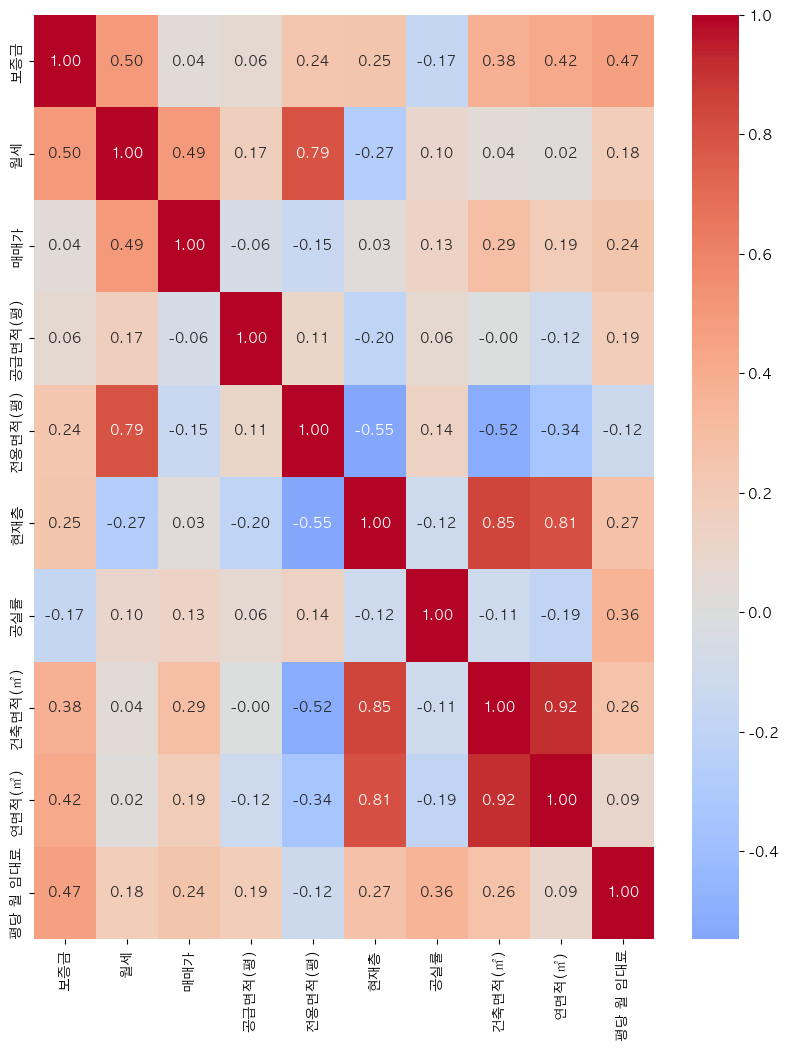

In [48]:
select_df = grouped_df.select_dtypes(include=[np.number])
corr_df = select_df.corr()
plt.figure(figsize=(10, 12))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0)

ML을 돌리기에는 너무 적은 데이터이다.

공실률 vs. 매매가/월세
→ 공실률이 낮은 곳이 비싼가? -> 공실률이 높을수록 매매가
지식산업센터별 면적 대비 가격
→ 어떤 센터가 가성비 좋은가?
지역별 (의왕 vs. 군포) 차이
→ 의왕과 군포 중 어디가 임대료가 더 높은가?
